In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from abstractModel import build_model, compare_result

In [47]:
sessions = pd.read_csv("../data/merged_sessions_products_data", sep=' ')
sessions = pd.get_dummies(sessions, columns = ['offered_discount', 'weekday'])

result_dict = {}

# print(sessions.head)
# print(sessions)

seed = 42
test_size = 0.1

X = sessions.drop('purchase', axis=1)
Y = sessions[['purchase']]

records_num = len(sessions)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [48]:
print('Size of entire dataset: ', records_num)
print('Size of training set: ', len(X_train))
print('Size of test set: ', len(X_test))

Size of entire dataset:  37003
Size of training set:  33302
Size of test set:  3701


<AxesSubplot:>

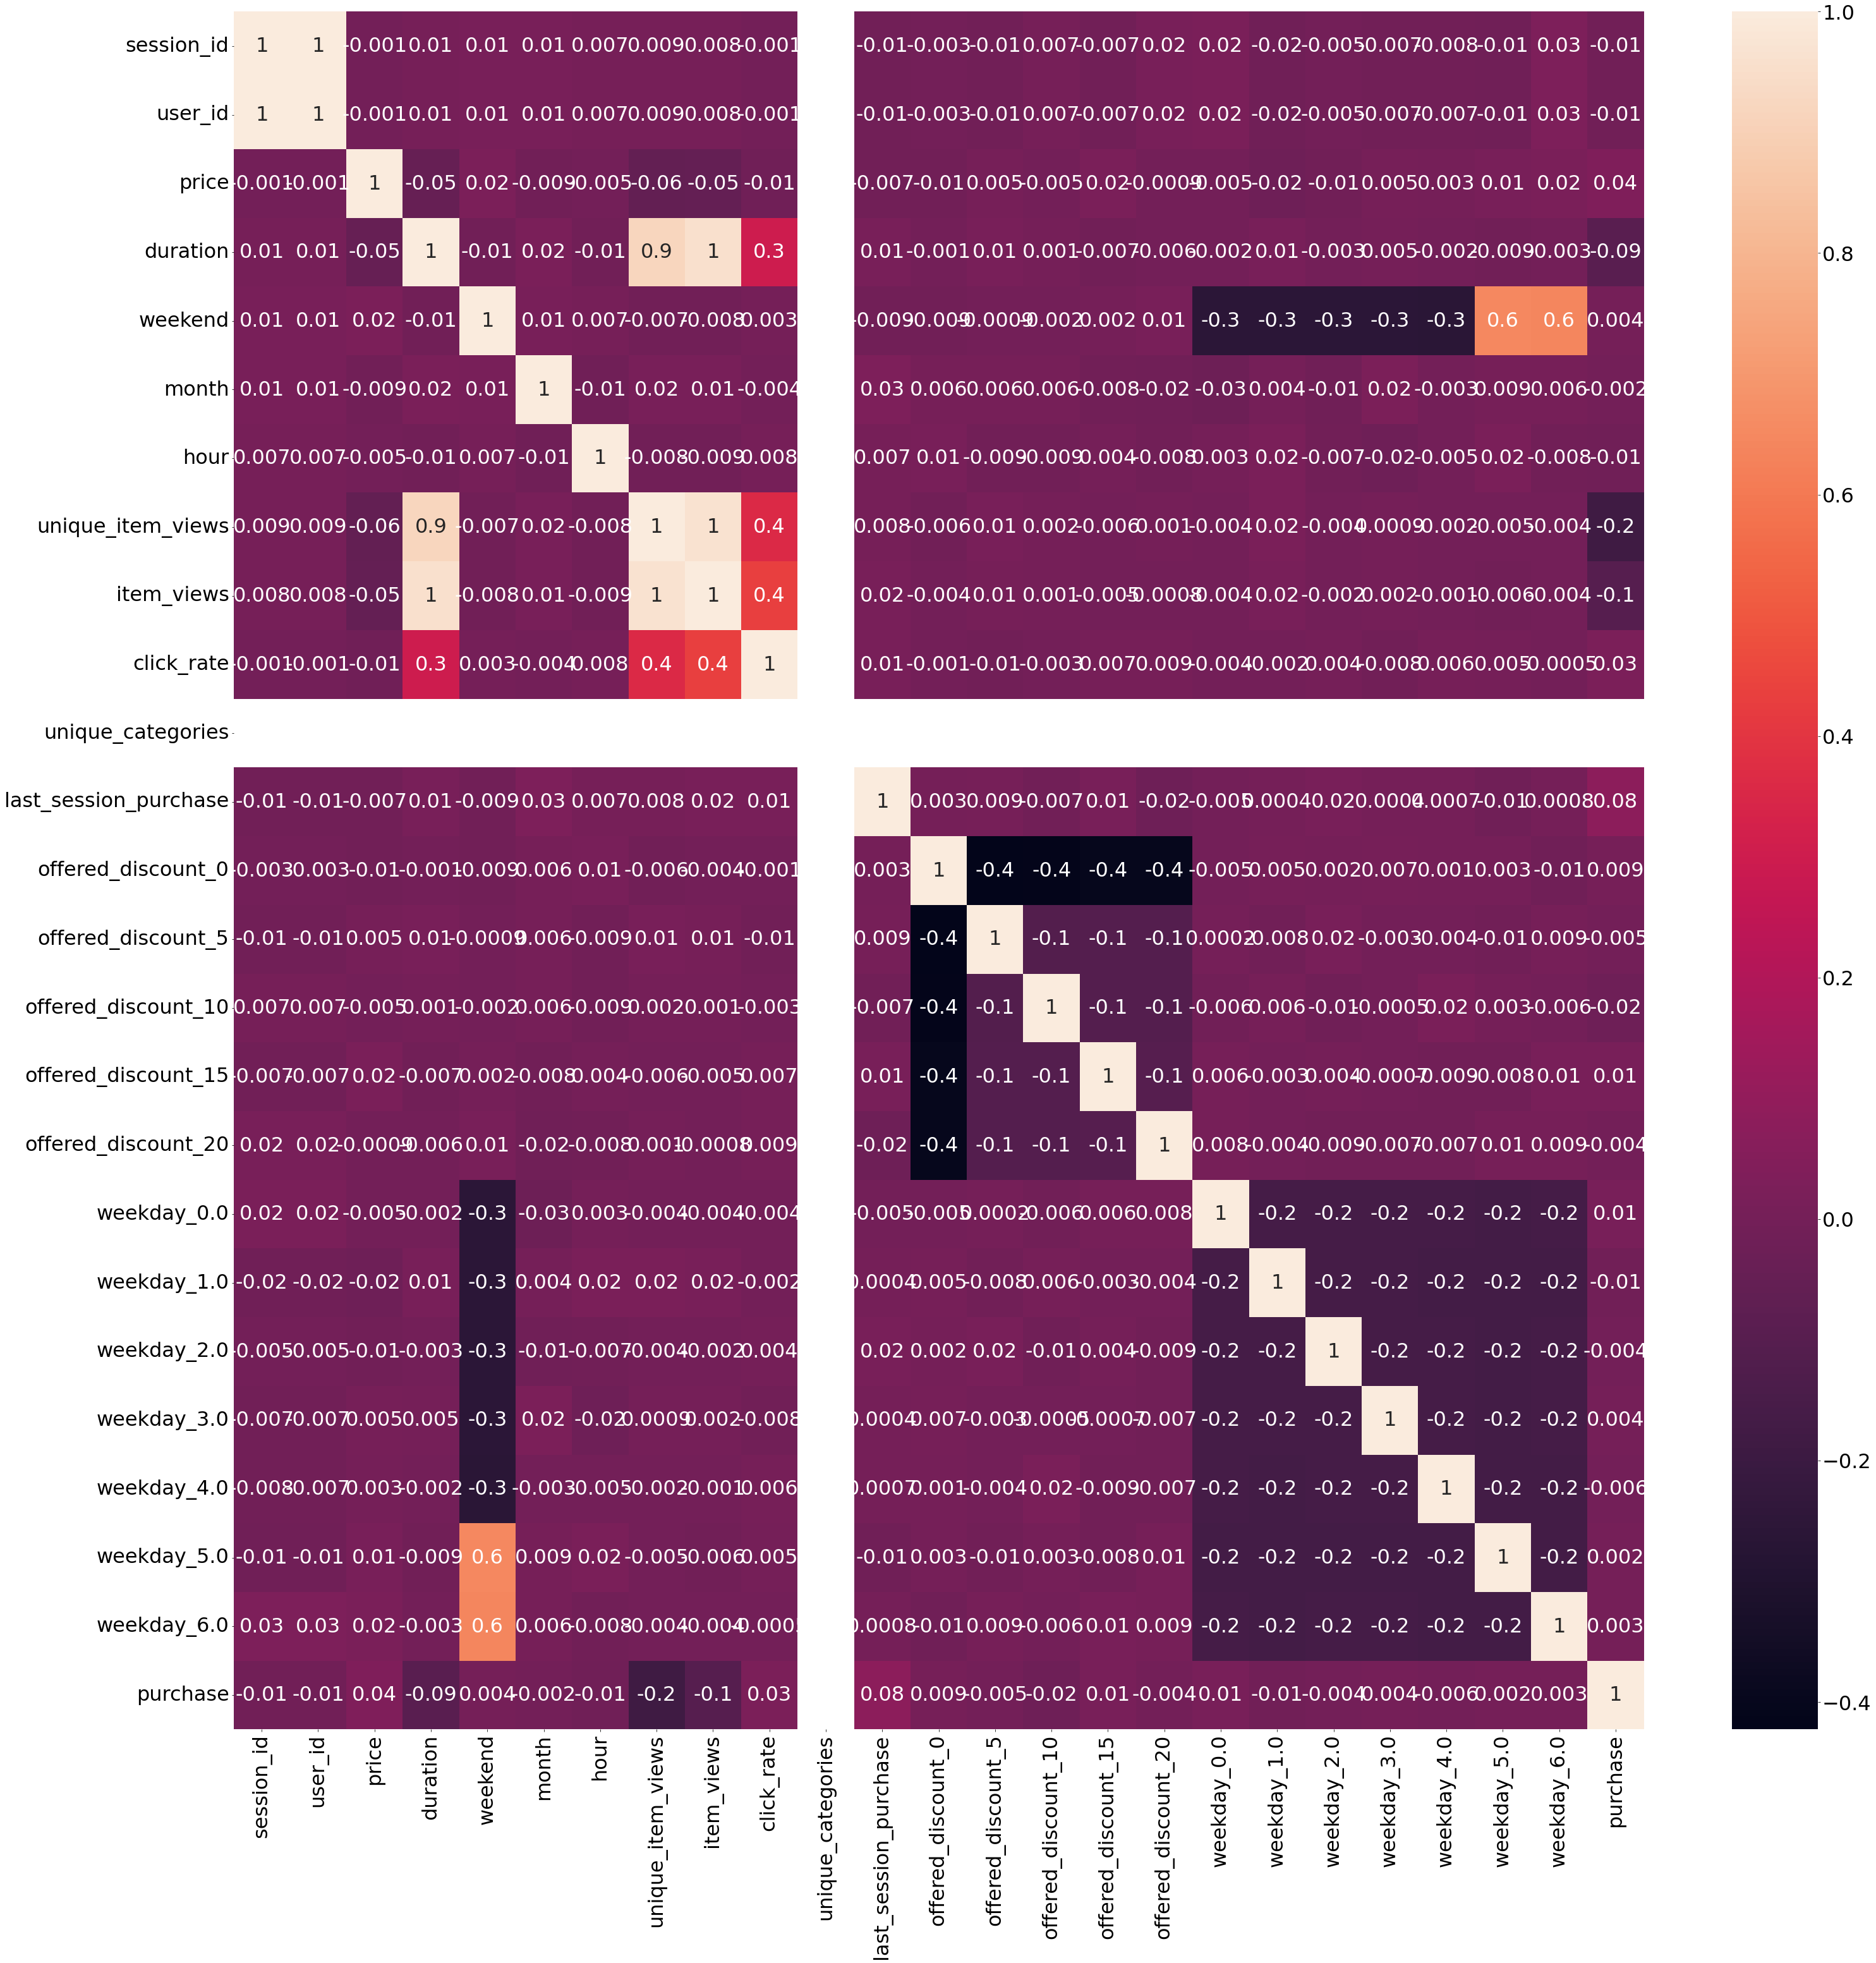

In [49]:
plt.rcParams['figure.figsize'] = [50, 50]
plt.rcParams.update({'font.size': 32})

train = pd.concat([X_train, Y_train], axis=1)

sns.heatmap(
    train.corr(method = 'spearman'),
    xticklabels = train.columns,
    yticklabels = train.columns,
    annot=True,
    fmt='0.1g'
)

In [50]:
list_one =[]
feature_ranking = SelectKBest(chi2, k=5)
fit = feature_ranking.fit(X_train, Y_train)

for i, (score, feature) in enumerate(zip(feature_ranking.scores_, X_train.columns)):
    list_one.append((score, feature))
    
dfObj = pd.DataFrame(list_one) 
dfObj = dfObj.sort_values(by=[0], ascending = False)

display(dfObj)

,0,1
3,132508.125086,duration
0,5424.582119,session_id
2,4840.795787,price
7,1520.036450,unique_item_views
8,549.720335,item_views
9,138.519401,click_rate
11,90.553812,last_session_purchase
1,69.037895,user_id
6,26.481205,hour
14,8.876992,offered_discount_10


In [51]:
result_dict = {}
dropped_cols_with_corelated_attr = list(dfObj[dfObj[0] < 1][1])
dropped_cols_with_corelated_attr.extend(['session_id'])

dropped_cols_without_corelated_attr = dropped_cols_with_corelated_attr[:]
dropped_cols_without_corelated_attr.extend(['unique_item_views'])
onehot_cols = ['hour']

In [52]:
def logistic_fn_tuning(X_train, Y_train):
    # hyperparameters tuning
    model = LogisticRegression(max_iter=500)
    # define evaluation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)

    # define search space
    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['l2']
    space['C'] = [100, 10, 1.0, 0.1, 0.01]

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    search = RandomizedSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv, random_state=seed)
    search.fit(X_train, Y_train)
    
    print(search.best_estimator_) # model = LogisticRegression(C=0.1, max_iter=500, solver='newton-cg')
    return search.best_estimator_

def logistic_fn(X_train, Y_train):
    model = LogisticRegression(C=0.1, max_iter=500, solver='newton-cg')
    model.fit(X_train, Y_train)
    
    return model

result_dict['Logistic Regression with corelated attributes'] = \
    build_model(logistic_fn, sessions, onehot_cols, dropped_cols_with_corelated_attr, 'purchase', seed, test_size)

result_dict['Logistic Regression without corelated attributes'] = \
    build_model(logistic_fn, sessions, onehot_cols, dropped_cols_without_corelated_attr, 'purchase', seed, test_size, output = './logistic_reg.pkl')
